In [1]:
# To run this in Google Colab, uncomment the following line
# !pip install "git+https://github.com/GPflow/GeometricKernels.git"

# If you want to use a version of the library from a different git branch,
# say, from the "devel" branch, uncomment the line below instedad
# !pip install "git+https://github.com/GPflow/GeometricKernels@devel#egg=GeometricKernels"

# Matérn and Heat Kernels on Spheres

This notebook shows how define and evaluate kernels on the two-dimensional sphere $\mathbb{S}_2 \subseteq \mathbb{R^3}$.

Handling hyperspheres $\mathbb{S}_d \subseteq \mathbb{R}^{d+1}$ for $d \geq 2$ is the same.
We chose to showcase $\mathbb{S}_2$ here because (1) it is probably the most well known case (2) it is easy to visualize.

**Note:** the points on the (hyper)sphere $\mathbb{S}_d$ are represented by vectors (`array`s of the suitable backend) in $\mathbb{R}^{d+1}$ whose Euclidean norm is equal to $1$.

We use the **numpy** backend here.

In [2]:
# Import a backend, we use numpy in this example.
import numpy as np
# Import the geometric_kernels backend.
import geometric_kernels
# Import a space and an appropriate kernel.
from geometric_kernels.spaces import Hypersphere
from geometric_kernels.kernels import MaternKarhunenLoeveKernel

import matplotlib as mpl
import matplotlib.pyplot as plt

INFO: Using numpy backend


## Defining a Space

First we create a GeometricKernels `space` that corresponds to the 2-dimensional sphere $\mathbb{S}_2$, a subset of $\mathbb{R}^3$.

In [3]:
sphere = Hypersphere(dim=2)

For *discrete spectrum spaces* such as the `Hypersphere` or other *compact manifolds*, the class `MaternKarhunenLoeveKernel` should be used.

## Theory (Optional Reading)
### General Theory Behind `MaternKarhunenLoeveKernel` for Compact Manifolds
`MaternKarhunenLoeveKernel` is given by the formula
$$
k_{\nu, \kappa}(x,x')
=
\frac{1}{C_{\nu, \kappa}} \sum_{n=1}^N \Phi_{\nu, \kappa}(\lambda_n) f_n(x) f_n(x')
\qquad
\qquad
\Phi_{\nu, \kappa}(\lambda)
=
\begin{cases}
\left(\frac{2\nu}{\kappa^2} + \lambda\right)^{-\nu-\frac{d}{2}}
&
\nu < \infty \text{ — Matérn}
\\
e^{-\frac{\kappa^2}{2} \lambda}
&
\nu = \infty \text{ — Heat (RBF)}
\end{cases}
$$
The notation is as follows.
* The values $\lambda_n \geq 0$ and the functions $f_n(\cdot)$ are *eigenvalues* and *eigenfunctions* of the *Laplace–Beltrami operator* on the compact Riemannian manifold.
The functions $\left\{f_n\right\}_{n=1}^{\infty}$ constitute an orthonormal basis of the space $L^2(M)$ of square integrable functions on the manifold $M$ with respect to the inner product $\langle f, g \rangle_{L^2(M)} = \frac{1}{|M|} \int_M f(x) g(x) \mathrm{d} x$.

* $d$ is the dimension of the manifold.

* $C_{\nu, \kappa}$ is the constant which ensures that average variance is equal to $1$, i.e. $\frac{1}{|M|}\int_M k(x, x) \mathrm{d} x = 1$ where $M$ denotes the manifold and $|M|$ its volume.
It is easy to show that $C_{\nu, \kappa} = \sum_{n=1}^N \Phi_{\nu, \kappa}(\lambda_n)$.

**Note:** For general manifolds $k(x, x)$ can vary from point to point.
You usually observe this for manifold represented by meshes, the ones which do not have a lot of symmetries.
On the other hand, for the hyperspheres $k(x, x)$ is a constant, as it is for all *homogenous spaces* which hyperspheres are instances of.


### `MaternKarhunenLoeveKernel` for Hyperspheres and Addition Theorem

When $M = \mathbb{S}_d$, i.e. the manifold is a (hyper)sphere, $\lambda_n$ and $f_n$ are known (see e.g. Appendix B of Borovitskiy et al. 2020).
Specifically, $f_n$ are the *(hyper)spherical harmonics*, restrictions on the unit sphere of certain known polynomials in $\mathbb{R}^{d+1}$ and $\lambda_n$ have closed form expression.

Although $\lambda_n, f_n$ are known for $M = \mathbb{S}_d$, using the general formula for $k(x, x')$ is suboptimal in this case because of the following theorem.

**Addition Theorem**.
The spherical harmonics $f_n$ can be re-indexed as $f_{j, s}$ with $j = 0 \ldots \infty$ and $s = 1 \ldots d_j$ such that all $\{f_{j, s}\}_{s=1}^{d_j}$ correspond to the same eigenvalue $\lambda_j = j(j+d-1)$ where $d_j = (2j+d-1) \frac{\Gamma(j+d-1)}{\Gamma(d) \Gamma(j+1)}$ where $\Gamma$ is the gamma function, $\Gamma(l) = (l-1)!$ for integer $l > 0$.
In this case
$$
\sum_{s=1}^{d_j} f_{j, s}(x) f_{j, s}(x')
=
c_{j, d} \mathcal{C}^{(d-1)/2}_j(\cos(\mathrm{d}_M(x, x')))
\qquad
\qquad
c_{j, d}
=
d_j \frac{\Gamma((d+1)/2)}{2 \pi^{(d+1)/2} \mathcal{C}_j^{(d-1)/2}(1)}
$$
where $\mathcal{C}^{(d-1)/2}_j$ are certain known polynomials called *Gegenbauer polynomials* and $\mathrm{d}_M(x, x')$ is the geodesic distance on the (hyper)sphere.

Thanks to this, we have

$$
k_{\nu, \kappa}(x,x')
=
\frac{1}{C_{\nu, \kappa}} \sum_{j=0}^J \Phi_{\nu, \kappa}(\lambda_j) c_{j, d} \mathcal{C}^{(d-1)/2}_j(\cos(\mathrm{d}_M(x, x')))
\qquad
\qquad
\Phi_{\nu, \kappa}(\lambda)
=
\begin{cases}
\left(\frac{2\nu}{\kappa^2} + \lambda\right)^{-\nu-\frac{d}{2}}
&
\nu < \infty \text{ — Matérn}
\\
e^{-\frac{\kappa^2}{2} \lambda}
&
\nu = \infty \text{ — Heat (RBF)}
\end{cases}
$$
which is actually used to evaluate the kernel. The reason is simple: it is not harder to evaluate Gegenbauer polynomials $\mathcal{C}^{(d-1)/2}_j$ than each one of the (hyper)spherical harmonics, and you need much less of the Gegenbauer polynomials to achieve the same quality of approximation.

For example, for $J = 20$ the corresponding $N$ is $441$.

## Defining a Kernel

First, we create a generic Matérn kernel.

To initialize `MaternKarhunenLoeveKernel`, you provide two parameters.
First, the `space`, in our case this is the `sphere` we have just created above.
The second parameter, `num_eigenfunctions`, determines the number of terms in the approximation to the infinite series that defines the paper.
The recommended value for the hypersphere is `20`: it gives a high-quality approximation without running into numerical issues caused by dealing with polynomials of too high powers.

**Note:** the `num_eigenfunctions` parameter is equal to $J-1$ in terms of the theory above, it corresponds to the number of unique eigenvalues (or, alternatively, to the number of Gegenbauer polynomials) used to approximate the kernel.

In [4]:
kernel = MaternKarhunenLoeveKernel(sphere, 30)

To support JAX, our classes do not contain a *state*, it is external.
The next line initializes the *state* which is composed of two parts: `params`, a dictionary with kernel parameters, and `state`, a dictionary containing the eigenpairs.

`params` are initialized with some default values.

**Note:** our kernels do not contain the outputscale/variance parameter frequently used in Gaussian processes.
However, it is usually trivial to add it by multiplying the kernel by an (optimizable) constant.

In [5]:
params, state = kernel.init_params_and_state()
print('params:', params)
print('state:', state)

params: {'lengthscale': array(1.), 'nu': array(inf)}
state: {'eigenvalues_laplacian': array([[  0],
       [  2],
       [  6],
       [ 12],
       [ 20],
       [ 30],
       [ 42],
       [ 56],
       [ 72],
       [ 90],
       [110],
       [132],
       [156],
       [182],
       [210],
       [240],
       [272],
       [306],
       [342],
       [380],
       [420],
       [462],
       [506],
       [552],
       [600],
       [650],
       [702],
       [756],
       [812],
       [870]]), 'eigenfunctions': <geometric_kernels.spaces.hypersphere.SphericalHarmonics object at 0x7f57e8175eb0>}


To define two different kernels, Matern-3/2 and Matern-∞ (aka heat, RBF, squared exponential, diffusion), we need two different versions of `params`:

In [6]:
params["lengthscale"] = np.array([0.125])
params_32  = params.copy()
params_inf = params.copy()
del params
params_32["nu"]  = np.array([3/2])
params_inf["nu"] = np.array([np.inf])

Now two kernels are *defined* and we proceed to evaluating both on a set of random inputs.

## Evaluating Kernels on Random Inputs

We start by sampling `10` (uniformly) random points on the sphere $\mathbb{S}_2$.
An explicit `key` parameter is needed to support JAX as one of the backends.

In [7]:
key = np.random.RandomState(1234)

key, xs = sphere.random(key, 10)

print(xs)

[[ 0.2453089  -0.61971816  0.74550181]
 [-0.26385701 -0.60812805  0.74870539]
 [ 0.80356397 -0.59503751  0.01467335]
 [-0.8280059   0.42459658  0.3662294 ]
 [ 0.42189482 -0.89450892 -0.14784637]
 [ 0.00425403  0.81421747  0.58054441]
 [ 0.64624279 -0.75666681 -0.09912418]
 [-0.74561122  0.21985349  0.62906943]
 [ 0.84836694 -0.30204652  0.43478896]
 [-0.86072199 -0.08673813  0.50163149]]


Now we evaluate the two kernel matrices.

In [8]:
kernel_mat_32  = kernel.K(params_32,  state, xs, xs)
kernel_mat_inf = kernel.K(params_inf, state, xs, xs)

Finally, we visualize these matrices using `imshow`.

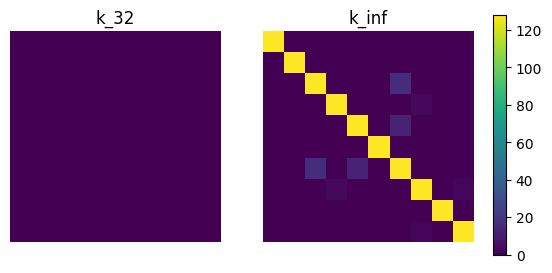

In [9]:
# find common range of values
minmin = np.min([np.min(kernel_mat_32), np.min(kernel_mat_inf)])
maxmax = np.max([np.max(kernel_mat_32), np.max(kernel_mat_inf)])

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
cmap = plt.get_cmap('viridis')

ax1.imshow(kernel_mat_32, vmin=minmin, vmax=maxmax, cmap=cmap)
ax1.set_title('k_32')
ax1.set_axis_off()

ax2.imshow(kernel_mat_inf, vmin=minmin, vmax=maxmax, cmap=cmap)
ax2.set_title('k_inf')
ax2.set_axis_off()

# add space for color bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.25, 0.02, 0.5])

# add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=minmin, vmax=maxmax))
fig.colorbar(sm, cax=cbar_ax)

plt.show()

## Visualize Kernels

The sphere $\mathbb{S}_2$ is one of the few manifolds we can easily visualize.
Because of this, beyond kernel matrices, we will plot the functions $k_{\nu, \kappa}(\text{pole}, \cdot)$.

In practice, we visualize $k_{\nu, \kappa}($ `base_point` $, x)$ for $x \in $ `other_points`.
The `base_point` is simply the north pole.
The `other_points` is defined by the `_NUM_LATS` x `_NUM_LONGS` uniform grid.

We define `base_point` and `other_points` in the next cell.

In [10]:
base_point = np.array([[0.0, 0.0, 1.0]])

# define latitude and longtitude discretization
_NUM_LATS = 128
_NUM_LONGS = 128

# generate a grid on the sphere
lats, longs =  np.mgrid[0:2*np.pi:_NUM_LATS*1j, 0:np.pi:_NUM_LONGS*1j]

xs = np.sin(longs) * np.cos(lats)
ys = np.sin(longs) * np.sin(lats)
zs = np.cos(longs)

other_points = np.c_[np.ravel(xs), np.ravel(ys), np.ravel(zs)]

The next cell evaluates $k_{\nu, \kappa}($ `base_point` $, x)$ for $x \in $ `other_points` for $\nu$ either $3/2$ or $\infty$.

In [11]:
kernel_vals_32  = kernel.K(params_32,  state, base_point, other_points)
kernel_vals_inf = kernel.K(params_inf, state, base_point, other_points)

Finally, we are ready to plot the results.

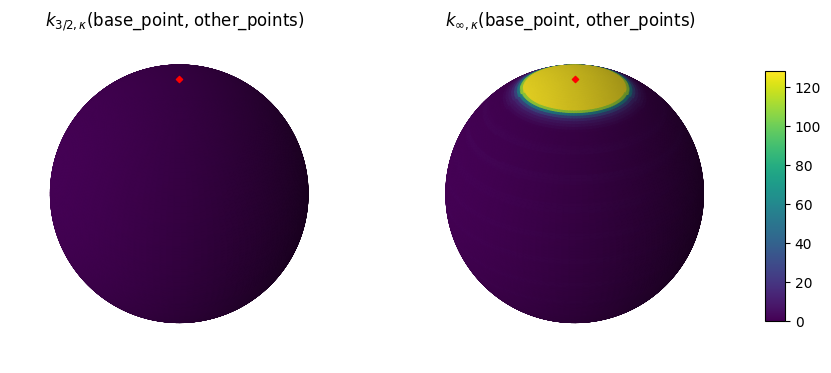

In [12]:
fig, (ax1, ax2) = plt.subplots(figsize= (10, 5), nrows=1, ncols=2,
                               subplot_kw=dict(projection='3d',
                                               computed_zorder=False))

cmap = plt.get_cmap('viridis')

surf1 = ax1.plot_surface(xs, ys, zs, facecolors=cmap(kernel_vals_32[0, :].reshape(_NUM_LATS, _NUM_LONGS)),  cstride=1, rstride=1)
surf2 = ax2.plot_surface(xs, ys, zs, facecolors=cmap(kernel_vals_inf[0, :].reshape(_NUM_LATS, _NUM_LONGS)), cstride=1, rstride=1)

# Remove axis
ax1._axis3don = False
ax2._axis3don = False

# Set aspect ratio
ax1.set_box_aspect((np.ptp(xs), np.ptp(ys), np.ptp(zs)), zoom=1.5)
ax2.set_box_aspect((np.ptp(xs), np.ptp(ys), np.ptp(zs)), zoom=1.5)

# plot the base point
ax1.scatter(base_point[0, 0], base_point[0, 1], base_point[0, 2], s=10, c='r', marker='D')
ax2.scatter(base_point[0, 0], base_point[0, 1], base_point[0, 2], s=10, c='r', marker='D')

# find common range of values
minmin_vis = np.min([np.min(kernel_vals_32), np.min(kernel_vals_inf)])
maxmax_vis = np.max([np.max(kernel_vals_32), np.max(kernel_vals_inf)])

ax1.set_title(r'$k_{3/2, \kappa}($base_point, other_points$)$')
ax2.set_title('$k_{\infty, \kappa}($base_point, other_points$)$')

# add color bar
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=minmin_vis, vmax=maxmax_vis))
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.25, 0.02, 0.5])
fig.colorbar(sm, cax=cbar_ax)

plt.show()

TODO: pictures should improve when normalization is introduced.

# Citation

If you are using (hyper)spheres and GeometricKernels, please consider citing

```
@article{borovitskiy2020,
    title={Matern Gaussian processes on Riemannian manifolds},
    author={Viacheslav Borovitskiy and Alexander Terenin and Peter Mostowsky and Marc Peter Deisenroth},
    booktitle={Advances in Neural Information Processing Systems},
    year={2020}}
```